In [9]:
import numpy as np
import pandas as pd
all_data = pd.read_csv('./all_data.csv')

In [15]:
%matplotlib inline
import shap
shap.initjs()

## カラム名を英語に変更

In [10]:
all_data_en = all_data.rename(columns={ 
'管理者兼作業者':'manager_and_operator',
'企画業務':'planning_tasks',
'ノンコア業務（自身が本来担当ではない業務）':'noncore_tasks',
'管理者':'manager',
'比較的慣れており，定型化できている業務':'standardized_tasks',
'コア業務（自身が本来担当している業務）':'core_tasks',
'共同作業者':'collaborators',
'開発業務':'development_tasks',
'管理業務':'manager_tasks',
'作業者/参加者':'operator/paticipants',
'管理の業務':'management_tasks',
'比較的新規性が高く，試行錯誤を伴う定型化できていない業務':'non_standardized_tasks',
'営業業務':'sales_tasks',
'事務業務（サポート業務、経理業務など）':'office_tasks',
'現場業務（主に肉体労働を伴うもの）':'field_tasks',
'現場（主に肉体労働を伴うもの）':'field',
'家（その他）':'home(other)',
'どちらでもない':'neither',
'一人':'alone',
'家（書斎など執務向けの場所）':'home(placeforwork)',
'他者あり（同僚など）':'with_others(colleagues_and)',
'家（リビングなど）':'home(living)',
'快適':'comfortable',
'職場外のワークスペース':'workspace_outside',
'他者あり（無干渉）':'with_others(nointeraction)',
'他者あり（同僚）':'with_others(colleagues)',
'職場':'workplace',
'他者あり（家族など）':'with_others(family)',
'店/外':'store/outside',
'不快':'uncomfortable',
'非常に快適':'very_comfortable',
'職場外ワークスペース':'workplace_outside_office',
'非常に不快':'extremely_uncomfortable'
})

all_data_en = all_data_en.rename(columns={
    '食事（業務時間外）':'meals(outofduty)',
'単独作業':'working_alone', 
'趣味・休憩':'hobbies/breaks', 
'家事・育児':'housework/childcare', 
'休憩（業務時間内）':'breaks(induty)', 
'移動':'travel', 
'Web会議':'web_conference', 
'その他':'other', 
'業務外作業':'non_work',
'対面会議':'facettoface_meetings', 
'共同作業（コミュニケーションを伴う）':'collaborative_work', 
'電話（会議）':'telephone(conference)'
})

In [28]:
all_column = all_data_en.columns

In [37]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
import japanize_matplotlib
# ques_act_day_pred['user_id'] = ques_act_day_pred['user_id'].astype('int')
target = 'depressive_score_label_m'

all_data_pre_en=all_data_en[all_data_en[target]!=1].dropna(subset=[target])
all_data_pre_en=all_data_pre_en[(all_data_pre_en[target]==0)|(all_data_pre_en[target]==2)]
X = all_data_pre_en[[
'manager_and_operator',
'planning_tasks',
'noncore_tasks',
'manager',
'standardized_tasks',
'core_tasks',
'collaborators',
'development_tasks',
'manager_tasks',
'operator/paticipants',
'management_tasks',
'non_standardized_tasks',
'sales_tasks',
'office_tasks',
'field_tasks',
'field',
'home(other)',
'neither',
'alone',
'home(placeforwork)',
'with_others(colleagues_and)',
'home(living)',
'comfortable',
'workspace_outside',
'with_others(nointeraction)',
'with_others(colleagues)',
'workplace',
'with_others(family)',
'store/outside',
'uncomfortable',
'very_comfortable',
'workplace_outside_office',
'extremely_uncomfortable'
                 
#         '対面会議', '食事', '単独作業', '趣味・休憩', '家事・育児', '休憩（業務時間内）',
#        '移動', 'web会議', 'その他', '業務外作業', '共同作業（コミュニケーションを伴う）', '電話（会議）',
    ]]
y = all_data_pre_en[target].replace(2,1).astype('int')

 # kfoldの分割数
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)
# 学習条件を設定
params = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric': {'binary_error'},
              'num_class': 1,
              'learning_rate': 0.02,
              'num_leaves': 23,
              'min_data_in_leaf': 1,
              'num_iteration': 1000,
              'verbose': 0,
              'reg_alpha':0.93,
              'reg_lambda':2.3
              }
    
acc_list = []
f1_list = []
auc_list = []
    
for train_index, test_index in skf.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
        
    # ここではvalidをモデル評価、evalをフォールドアウト検証に使う・・・分割の大きさはデータセットと相談する
    X_eval, X_valid, y_eval, y_valid = train_test_split(X_test, y_test, random_state=90, 
                                                            shuffle=True, stratify=y_test, test_size=0.3)
    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)

    # モデル評価用
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    # 学習する
    model = lgb.train(params,
                          lgb_train,
                          num_boost_round=70,
                          valid_sets=lgb_valid,
                          early_stopping_rounds=20)
        
    y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = [0 if i < 0.5 else 1 for i in y_pred_prob]
        
    # acc : 正答率
    acc = accuracy_score(y_test,y_pred)
    print('Acc :', acc)
    # f1-score
    f1 = f1_score(y_test,y_pred)
    print('f1-score :', f1)
    # logloss 
    logloss =  log_loss(y_test,y_pred_prob) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
    print('logloss :', logloss)
    # AUC 
    auc = roc_auc_score(y_test,y_pred_prob) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
    print('AUC :', auc) 
        
    acc_list.append(acc)
    f1_list.append(f1)
    auc_list.append(auc)
        
print('Kfold平均 acc:{}, f1-score:{}, auc:{}'.format(np.mean(acc_list), 
                                                         np.mean(f1_list), 
                                                         np.mean(auc_list)))
column = 'importance_'+ target
# importanceを表示する
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=list(X.columns), columns=[column])
display(importance.sort_values(column, ascending=False))
good_columns=importance.sort_values(column, ascending=False).index[0:30]

Found `num_iteration` in params. Will use it instead of argument
Found `num_iteration` in params. Will use it instead of argument
Found `num_iteration` in params. Will use it instead of argument
Found `num_iteration` in params. Will use it instead of argument
Found `num_iteration` in params. Will use it instead of argument
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's binary_error: 0.0930233
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_error: 0.0930233
[3]	valid_0's binary_error: 0.116279
[4]	valid_0's binary_error: 0.116279
[5]	valid_0's binary_error: 0.116279
[6]	valid_0's binary_error: 0.116279
[7]	valid_0's binary_error: 0.116279
[8]	valid_0's binary_error: 0.116279
[9]	valid_0's binary_error: 0.116279
[10]	valid_0's binary_error: 0.116279
[11]	valid_0

,importance_depressive_score_label_m
manager_and_operator,919.575611
non_standardized_tasks,603.319103
neither,545.937901
with_others(nointeraction),346.406789
core_tasks,285.906800
development_tasks,167.541197
standardized_tasks,166.099672
alone,159.076630
home(living),139.946359
uncomfortable,135.054609


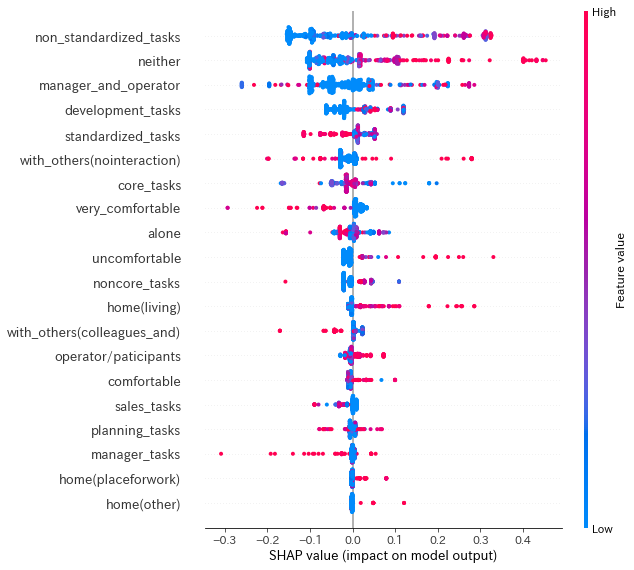

In [38]:
explainer = shap.TreeExplainer(model, data=X_train)
tr_x_shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values=tr_x_shap_values,
                  features=X_train,
                  feature_names=X_train.columns)

Found `num_iteration` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's binary_error: 0.276596
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_error: 0.276596
[3]	valid_0's binary_error: 0.276596
[4]	valid_0's binary_error: 0.276596
[5]	valid_0's binary_error: 0.276596
[6]	valid_0's binary_error: 0.276596
[7]	valid_0's binary_error: 0.276596
[8]	valid_0's binary_error: 0.276596
[9]	valid_0's binary_error: 0.276596
[10]	valid_0's binary_error: 0.276596
[11]	valid_0's binary_error: 0.276596
[12]	valid_0's binary_error: 0.276596
[13]	valid_0's binary_error: 0.276596
[14]	valid_0's binary_error: 0.276596
[15]	valid_0's binary_error: 0.276596
[16]	valid_0's binary_error: 0.276596
[17]	valid_0's binary_error: 0.276596
[18]	valid_0's binary_error: 0.276596
[19]	valid_0's binary_error: 0.2765

Found `num_iteration` in params. Will use it instead of argument
Found `num_iteration` in params. Will use it instead of argument
Found `num_iteration` in params. Will use it instead of argument
Found `num_iteration` in params. Will use it instead of argument


Acc : 0.7189542483660131
f1-score : 0.8365019011406843
logloss : 0.5873794039992162
AUC : 0.8473572938689218
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's binary_error: 0.282609
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_error: 0.282609
[3]	valid_0's binary_error: 0.282609
[4]	valid_0's binary_error: 0.282609
[5]	valid_0's binary_error: 0.282609
[6]	valid_0's binary_error: 0.282609
[7]	valid_0's binary_error: 0.282609
[8]	valid_0's binary_error: 0.282609
[9]	valid_0's binary_error: 0.282609
[10]	valid_0's binary_error: 0.282609
[11]	valid_0's binary_error: 0.282609
[12]	valid_0's binary_error: 0.282609
[13]	valid_0's binary_error: 0.282609
[14]	valid_0's binary_error: 0.282609
[15]	valid_0's binary_error: 0.282609
[16]	valid_0's binary_error: 0.282609
[1

,importance_positive_score_label_y
一人,88.311100
共同作業者,18.692701
職場,14.636739
快適,14.395200
コア業務（自身が本来担当している業務）,10.885300
どちらでもない,10.147200
家（リビングなど）,9.748520
企画業務,9.509260
管理者,8.418440
事務業務（サポート業務、経理業務など）,6.436660


<AxesSubplot:>

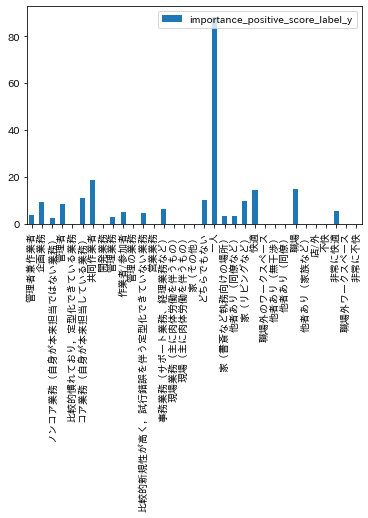

In [6]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
import japanize_matplotlib
# ques_act_day_pred['user_id'] = ques_act_day_pred['user_id'].astype('int')
target = 'positive_score_label_y'

all_data_pre=all_data[all_data[target]!=1].dropna(subset=[target])
X = all_data_pre[[
        '管理者兼作業者', '企画業務', 'ノンコア業務（自身が本来担当ではない業務）', '管理者',
       '比較的慣れており，定型化できている業務', 'コア業務（自身が本来担当している業務）', '共同作業者', '開発業務', '管理業務',
       '作業者/参加者', '管理の業務', '比較的新規性が高く，試行錯誤を伴う定型化できていない業務', '営業業務',
       '事務業務（サポート業務、経理業務など）', '現場業務（主に肉体労働を伴うもの）', '現場（主に肉体労働を伴うもの）', '家（その他）',
       'どちらでもない', '一人', '家（書斎など執務向けの場所）', '他者あり（同僚など）', '家（リビングなど）', '快適',
       '職場外のワークスペース', '他者あり（無干渉）', '他者あり（同僚）', '職場', '他者あり（家族など）', '店/外', '不快',
       '非常に快適', '職場外ワークスペース', '非常に不快',
                 
#         '対面会議', '食事', '単独作業', '趣味・休憩', '家事・育児', '休憩（業務時間内）',
#        '移動', 'web会議', 'その他', '業務外作業', '共同作業（コミュニケーションを伴う）', '電話（会議）',
    ]]
y = all_data_pre[target].replace(2,1).astype('int')

 # kfoldの分割数
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)
# 学習条件を設定
params = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric': {'binary_error'},
              'num_class': 1,
              'learning_rate': 0.02,
              'num_leaves': 23,
              'min_data_in_leaf': 1,
              'num_iteration': 1000,
              'verbose': 0,
              'reg_alpha':0.93,
              'reg_lambda':2.3
              }
    
acc_list = []
f1_list = []
auc_list = []
    
for train_index, test_index in skf.split(X, y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
        
    # ここではvalidをモデル評価、evalをフォールドアウト検証に使う・・・分割の大きさはデータセットと相談する
    X_eval, X_valid, y_eval, y_valid = train_test_split(X_test, y_test, random_state=90, 
                                                            shuffle=True, stratify=y_test, test_size=0.3)
    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)

    # モデル評価用
    lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    # 学習する
    model = lgb.train(params,
                          lgb_train,
                          num_boost_round=70,
                          valid_sets=lgb_valid,
                          early_stopping_rounds=20)
        
    y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = [0 if i < 0.5 else 1 for i in y_pred_prob]
        
    # acc : 正答率
    acc = accuracy_score(y_test,y_pred)
    print('Acc :', acc)
    # f1-score
    f1 = f1_score(y_test,y_pred)
    print('f1-score :', f1)
    # logloss 
    logloss =  log_loss(y_test,y_pred_prob) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
    print('logloss :', logloss)
    # AUC 
    auc = roc_auc_score(y_test,y_pred_prob) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
    print('AUC :', auc) 
        
    acc_list.append(acc)
    f1_list.append(f1)
    auc_list.append(auc)
        
print('Kfold平均 acc:{}, f1-score:{}, auc:{}'.format(np.mean(acc_list), 
                                                         np.mean(f1_list), 
                                                         np.mean(auc_list)))
column = 'importance_'+ target
# importanceを表示する
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=list(X.columns), columns=[column])
display(importance.sort_values(column, ascending=False))
good_columns=importance.sort_values(column, ascending=False).index[0:30]
importance.plot.bar()

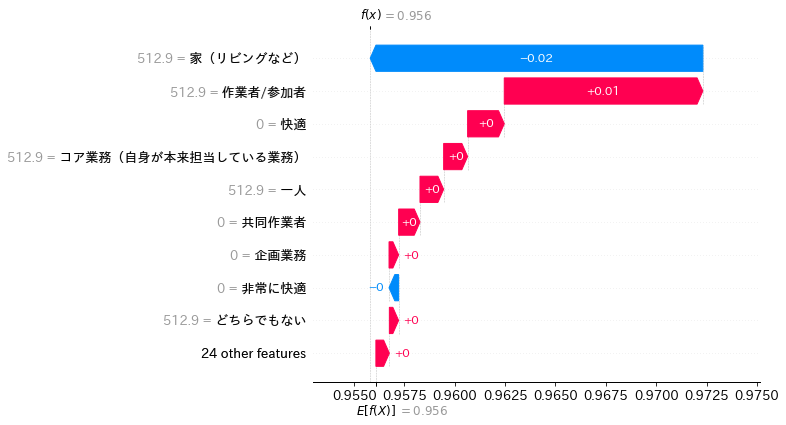

In [8]:
explainer = shap.Explainer(model, X_valid)
shap_values = explainer(X_valid)
shap.plots.waterfall(shap_values[13])

In [9]:
shap.waterfall_plot(explainer.expected_value, shap_values[0,:], feature_names=X_train.columns.values, max_display=5, show=True)

TypeError: waterfall() got an unexpected keyword argument 'feature_names'

In [ ]:
shap.decision_plot(base_value=explainer.expected_value,
                shap_values=tr_x_shap_values,
                features=X_valid,
                feature_names=list(X_valid.columns))

## 特徴量重要度の可視化

In [47]:
all_importance_kind = pd.read_csv('./kind_dams_importance.csv')
all_importance_detail = pd.read_csv('./detail_dams_importance.csv')
all_importance_kind = all_importance_kind.set_index('Unnamed: 0')
for i in range(len(all_importance_kind.columns)):
    column = all_importance_kind.columns[i]
    print(column)
    # print(all_importance_kind[column].sum())
    normal_imp_kind = all_importance_kind
    normal_imp_kind[column] = all_importance_kind[column]/all_importance_kind[column].sum()

importance_positive_score_label_morning
importance_depressive_score_label_morning
importance_anxious_score_label_morning
importance_positive_score_label_night
importance_depressive_score_label_night
importance_anxious_score_label_night


In [56]:
normal_imp_kind.index

Index(['対面会議', '食事', '単独作業', '趣味・休憩', '家事・育児', '休憩（業務時間内）', '移動', 'web会議',
       'その他', '業務外作業', '共同作業（コミュニケーションを伴う）', '電話（会議）'],
      dtype='object', name='Type of behavior')

Index(['importance_positive_score_label_morning',
       'importance_depressive_score_label_morning',
       'importance_anxious_score_label_morning',
       'importance_positive_score_label_night',
       'importance_depressive_score_label_night',
       'importance_anxious_score_label_night'],
      dtype='object')


<AxesSubplot:ylabel='Type of behavior'>

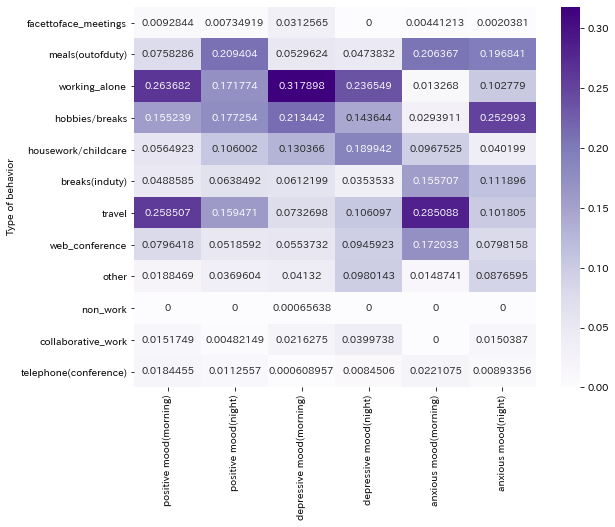

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
print(all_importance_kind.columns)
normal_imp_kind = all_importance_kind.reset_index().rename(columns={'Unnamed: 0':'Type of behavior'}).set_index('Type of behavior')
normal_imp_kind = normal_imp_kind.rename(index={
    '対面会議':'facettoface_meetings', 
    '食事':'meals(outofduty)', 
    '単独作業':'working_alone', 
    '趣味・休憩':'hobbies/breaks', 
    '家事・育児':'housework/childcare', 
    '休憩（業務時間内）':'breaks(induty)', 
    '移動':'travel', 
    'web会議':'web_conference', 
    'その他':'other', 
    '業務外作業':'non_work', 
    '共同作業（コミュニケーションを伴う）':'collaborative_work', 
    '電話（会議）':'telephone(conference)'
},columns={
    'importance_positive_score_label_morning':'positive mood(morning)',
    'importance_positive_score_label_night':'positive mood(night)',
    'importance_depressive_score_label_morning':'depressive mood(morning)' , 
    'importance_depressive_score_label_night':'depressive mood(night)',
    'importance_anxious_score_label_morning':'anxious mood(morning)', 
    'importance_anxious_score_label_night':'anxious mood(night)'
    })
# normal_imp_detail = normal_imp_detail[['肯定的気分（朝）','肯定的気分（夜）', '抑うつ気分（朝）' , '抑うつ気分（夜）', '不安気分（朝）', '不安気分（夜）']]
normal_imp_kind = normal_imp_kind[['positive mood(morning)','positive mood(night)','depressive mood(morning)' ,'depressive mood(night)','anxious mood(morning)', 'anxious mood(night)']]
plt.figure(figsize=(9, 7))
sns.heatmap(normal_imp_kind, annot=True, fmt='g', cmap='Purples')

Index(['Unnamed: 0', 'importance_positive_score_label_morning',
       'importance_depressive_score_label_morning',
       'importance_anxious_score_label_morning',
       'importance_positive_score_label_night',
       'importance_depressive_score_label_night',
       'importance_anxious_score_label_night'],
      dtype='object')


<AxesSubplot:ylabel='Detail of behavior'>

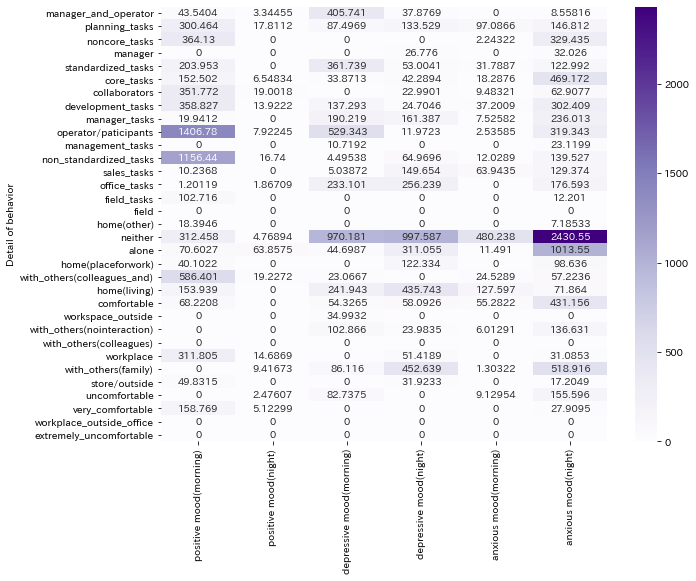

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
print(all_importance_detail.columns)
normal_imp_detail = all_importance_detail.reset_index().rename(columns={'Unnamed: 0':'Detail of behavior'}).set_index('Detail of behavior')
normal_imp_detail = normal_imp_detail.rename(index={
 '管理者兼作業者':'manager_and_operator',
 '企画業務': 'planning_tasks',
'ノンコア業務（自身が本来担当ではない業務）':'noncore_tasks',
'管理者':'manager',
'比較的慣れており，定型化できている業務':'standardized_tasks',
'コア業務（自身が本来担当している業務）':'core_tasks',
'共同作業者':'collaborators',
'開発業務':'development_tasks',
'管理業務':'manager_tasks',
'作業者/参加者':'operator/paticipants',
'管理の業務':'management_tasks',
'比較的新規性が高く，試行錯誤を伴う定型化できていない業務':'non_standardized_tasks',
'営業業務':'sales_tasks',
'事務業務（サポート業務、経理業務など）':'office_tasks',
'現場業務（主に肉体労働を伴うもの）':'field_tasks',
'現場（主に肉体労働を伴うもの）':'field',
'家（その他）':'home(other)',
'どちらでもない':'neither',
'一人':'alone',
'家（書斎など執務向けの場所）':'home(placeforwork)',
'他者あり（同僚など）':'with_others(colleagues_and)',
'家（リビングなど）':'home(living)',
'快適':'comfortable',
'職場外のワークスペース':'workspace_outside',
'他者あり（無干渉）':'with_others(nointeraction)',
'他者あり（同僚）':'with_others(colleagues)',
'職場':'workplace',
'他者あり（家族など）':'with_others(family)',
'店/外':'store/outside',
'不快':'uncomfortable',
'非常に快適':'very_comfortable',
'職場外ワークスペース':'workplace_outside_office',
'非常に不快':'extremely_uncomfortable'
},columns={
    'importance_positive_score_label_morning':'positive mood(morning)',
    'importance_positive_score_label_night':'positive mood(night)',
    'importance_depressive_score_label_morning':'depressive mood(morning)' , 
    'importance_depressive_score_label_night':'depressive mood(night)',
    'importance_anxious_score_label_morning':'anxious mood(morning)', 
    'importance_anxious_score_label_night':'anxious mood(night)'
    })
# normal_imp_detail = normal_imp_detail[['肯定的気分（朝）','肯定的気分（夜）', '抑うつ気分（朝）' , '抑うつ気分（夜）', '不安気分（朝）', '不安気分（夜）']]
normal_imp_detail = normal_imp_detail[['positive mood(morning)','positive mood(night)','depressive mood(morning)' ,'depressive mood(night)','anxious mood(morning)', 'anxious mood(night)']]
plt.figure(figsize=(10, 8))
sns.heatmap(normal_imp_detail, annot=True, fmt='g', cmap='Purples')